In [3]:
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

import uvotimgpy.utils.image_operation
importlib.reload(uvotimgpy.utils.image_operation)
from uvotimgpy.utils.image_operation import DS9Converter, rotate_image, align_images
from uvotimgpy.uvot_image.star_cleaner import BackgroundCleaner
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

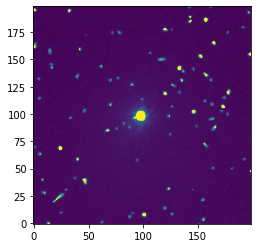

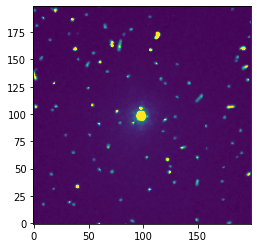

In [5]:
img_dict = {'18':(760,872),
            #'20':(773,884),
            '24':(766,877),
            #'26':(778,889)
            }
img_list = []
target_list = []
for imgid in img_dict.keys():
    x, y = img_dict[imgid]
    hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/'+imgid+'.fits')
    img = hdul[1].data
    angle = float(hdul[1].header['ORIENTAT'])
    col, row = DS9Converter.ds9_to_coords(x, y)[2:]
    target_list.append((col, row))

    img = rotate_image(img, target_coord=(col, row), angle=angle, fill_value=np.nan)
    img_list.append(img)

new_source_coord_ds9 = (100,100)
col, row = DS9Converter.ds9_to_coords(new_source_coord_ds9[0], new_source_coord_ds9[1])[2:]
img_list = align_images(img_list, target_list, (col, row))

for img in img_list:
    plt.imshow(img, vmin=0, vmax=2, origin='lower')
    plt.show()

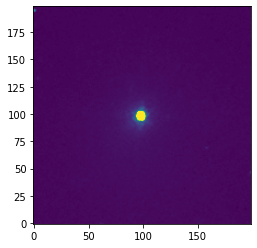

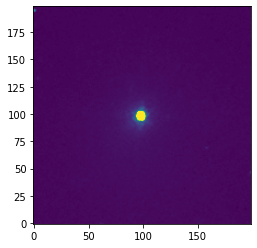

In [6]:
img_a = img_list[0]
img_b = img_list[1]
cleaner = BackgroundCleaner()
cleaned_a, cleaned_b = cleaner.process_image_pair(img_a, img_b)

plt.imshow(cleaned_a, vmin=0, vmax=2, origin='lower')
plt.show()

plt.imshow(cleaned_b, vmin=0, vmax=2, origin='lower')
plt.show()


The two images are almost the same, which indicates a over-mask.

In [17]:
import sys
import os
import importlib
sys.path.append(os.path.abspath('../'))

import uvotimgpy.utils.image_operation
import uvotimgpy.uvot_image.star_cleaner
importlib.reload(uvotimgpy.utils.image_operation)
importlib.reload(uvotimgpy.uvot_image.star_cleaner)
from uvotimgpy.utils.image_operation import DS9Converter, crop_image
from uvotimgpy.uvot_image.star_cleaner import StarIdentifier, PixelFiller
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

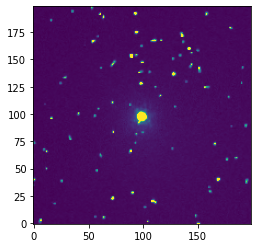

In [16]:
hdul = fits.open('/Volumes/ZexiWork/data/HST/29P/2019/18.fits')
img = hdul[1].data
x, y = 760, 872
col, row = DS9Converter.ds9_to_coords(x, y)[2:]
new_source_coord_ds9 = (100,100)
col_new, row_new = DS9Converter.ds9_to_coords(new_source_coord_ds9[0], new_source_coord_ds9[1])[2:]
img_cropped = crop_image(img, (col, row), (col_new, row_new))

plt.imshow(img_cropped, vmin=0, vmax=2, origin='lower')
plt.show()

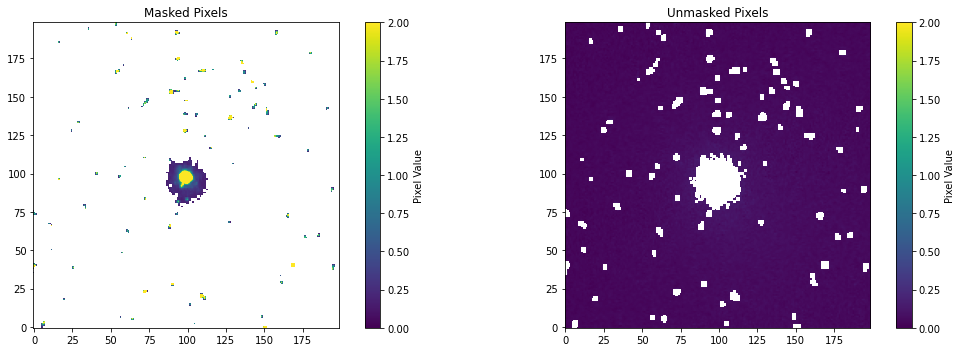

In [4]:
identifier = StarIdentifier()
mask = identifier.by_sigma_clip(img_cropped)

from uvotimgpy.base.visualizer import MaskInspector
inspector = MaskInspector(img_cropped, mask)
inspector.show_comparison(vmin=0,vmax=2)

In [21]:
def plotRing(r, center, color='r', ls='-',lw=0.5,alpha=1):
    theta = np.arange(0,2*np.pi,0.01)
    if isinstance(r, np.ndarray):
        for ri in r:
            plt.plot(ri*np.cos(theta)+center[0],ri*np.sin(theta)+center[1],color=color,ls=ls,lw=lw,alpha=alpha)
    else:
        plt.plot(r*np.cos(theta)+center[0],r*np.sin(theta)+center[1],color=color,ls=ls,lw=lw,alpha=alpha)

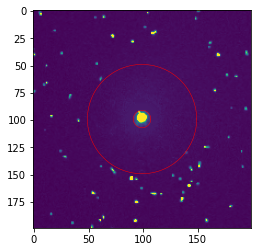

In [22]:
filler = PixelFiller()
step = 2
center_new = (col_new, row_new)
image_filled, radii, values = filler.by_rings(image=img_cropped, mask=mask, center=center_new, step=step, start=2, end=50)
r_min = np.min(radii)-step/2
r_max = np.max(radii)+step/2
plt.imshow(image_filled, vmin=0, vmax=2)
plotRing(np.array([r_min,r_max]),center_new)
plt.show()